# HỒI QUY LOGISTIC NHIỀU LỚP (MULTINOMIAL LOGISTIC REGRESSION)

In [1]:
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy import sparse

import sklearn
# from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_20newsgroups_vectorized

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Ví dụ 1

**Tự xây dựng các phương thức chính của mô hình hồi quy Logistic nhiều lớp, chỉ dựa vào các công cụ cơ bản trong thư viện Numpy**

**Khai báo thư viện/ thông số mô hình (số chiều, điểm dữ liệu) và tạo tập dữ liệu**

In [2]:
# randomly generate data
N = 500 # number of training sample
d = 2 # data dimension
C = 3 # number of classes (for c = 0, 1, 2)

means = [[2, 2], [8, 3], [3, 6]] # centeroid of each class dataset
cov = [[1, 0], [0, 1]]

# generate 3 classes of datasets
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

# each column is a datapoint (arrange 3 vectors X1 X2 X3 then transpose matrix)
X = np.concatenate((X0, X1, X2), axis = 0).T

# extended data by add row ONES (equivalent to 1) at first place
X = np.concatenate((np.ones((1, 3*N)), X), axis = 0)

# Generate label for data points of each class (0, 1, 2)
# with first 500 will belong to class 0, second 500 => 1 and last 500=> class 2
original_label = np.asarray([0]*N + [1]*N + [2]*N).T

In dữ liệu ra màn hình để hình dung trực quan

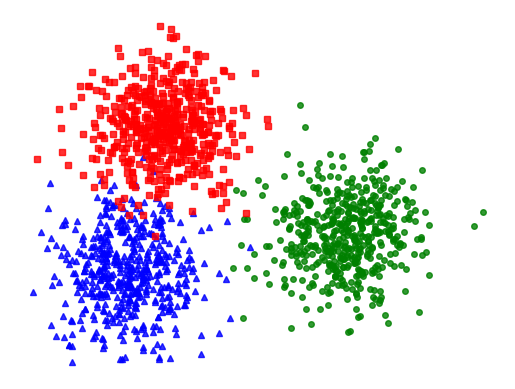

In [3]:
def display(X, label):
  X0 = X[:, label == 0]
  X1 = X[:, label == 1]
  X2 = X[:, label == 2]
  plt.plot(X0[0, :], X0[1,:], 'b^', markersize = 4, alpha = .8)
  plt.plot(X1[0, :], X1[1,:], 'go', markersize = 4, alpha = .8)
  plt.plot(X2[0, :], X2[1,:], 'rs', markersize = 4, alpha = .8)
  plt.axis('off')
  plt.plot()
  plt.show()

display(X[1:, :], original_label)

### **Xây dựng các phương thức cần cho mô hình hồi quy logistic nhiều lớp:**

Hàm chuyển từ một vector dữ liệu sang dạng one-hot-coding tức là các vector chỉ gồm 0/1/2 ứng với các
nhãn của điểm dữ liệu:

In [4]:
def convert_labels(y, C):
    """
    Convert 1d label to a matrix label: each column of this
    matrix corresponding to 1 element in y. In i-th column of Y,
    only one non-zero element located in the y[i]-th position, and = 1.
    Example: y = [0, 2, 1, 0], and 3 classes then return

    [[1, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))),
                          shape=(C, len(y))).toarray()
    return Y

def softmax_stable(Z):
    """
    Compute softmax values for each set of scores in Z.
    Each column of Z is a set of scores.
    """
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = e_Z / e_Z.sum(axis=0)
    return A

def softmax(Z):
    """
    Compute softmax values for each set of scores in Z.
    Each column of Z is a set of scores.
    """
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis=0)
    return A

def softmax_regression(X, y, W_init, eta, tol=1e-4, max_count=10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 20
    while count < max_count:
        # Mix data
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta * xi.dot((yi - ai).T)
            count += 1
            # Stopping criteria
            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def cost(X, Y, W):
    A = softmax(W.T.dot(X))
    return -np.sum(Y * np.log(A))

def pred(W, X):
    """
    Predict output of each column of X.
    Class of each x_i is determined by the location of max probability.
    Note that classes are indexed by [0, 1, 2, ...., C-1]
    """
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis=0)

In ra kết quả (bộ hệ số w)

In [5]:
# W[-1] is the solution, W is all history of weights
eta = .05
d = X.shape[0]
W_init = np.random.randn(X.shape[0], C)
W = softmax_regression(X, original_label, W_init, eta)
print(W[-1])

[[ 8.02814272 -4.60805133 -4.15280052]
 [-1.09776573  1.70971977 -0.83712575]
 [-1.06347086 -1.02234664  1.61357121]]


Phần code in kết quả trực quan

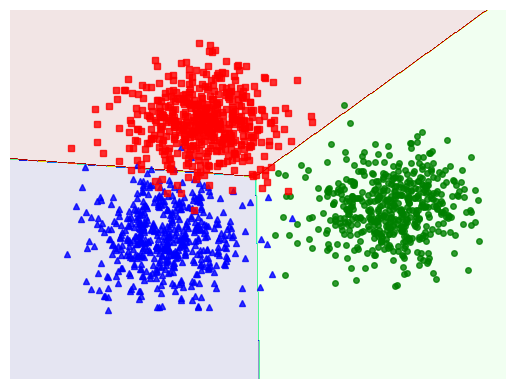

<Figure size 640x480 with 0 Axes>

In [6]:
# Visualize
xm = np.arange(-2, 11, 0.025)
ym = np.arange(-3, 10, 0.025)
xx, yy = np.meshgrid(xm, ym)

xx_flat = xx.ravel().reshape(1, -1)
yy_flat = yy.ravel().reshape(1, -1)

XX = np.vstack((np.ones(xx_flat.shape), xx_flat, yy_flat))
Z = pred(W[-1], XX).reshape(xx.shape)

CS = plt.contourf(xx, yy, Z, 200, cmap='jet', alpha=0.1)

plt.xlim(-2, 11)
plt.ylim(-3, 10)
plt.xticks(())
plt.yticks(())

display(X[1:, :], original_label)
plt.savefig('ex1.png', bbox_inches='tight', dpi=300)
plt.show()

## Ví dụ 2

Trực quan hóa dữ liệu IRIS

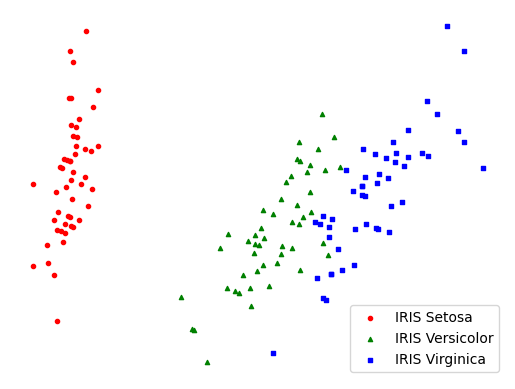

In [7]:
# import some data to play with
iris = datasets.load_iris()

X = iris.data[:, :4] # we take full 4 features
Y = iris.target

# Normalize data
X_norm = (X - X.min())/(X.max() - X.min())
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm))

plt.axis("off")
plt.scatter(transformed[Y==0][0], transformed[Y==0][1], s=9, label='IRIS Setosa', c='red')
plt.scatter(transformed[Y==1][0], transformed[Y==1][1], s=9, label='IRIS Versicolor', c='green', marker="^")
plt.scatter(transformed[Y==2][0], transformed[Y==2][1], s=9, label='IRIS Virginica', c='blue', marker="s")
plt.legend()
plt.show()

In [8]:
from sklearn import datasets, model_selection
np.random.seed(2)

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :4] # we take full 4 features
Y = iris.target

# split data into training and test sets
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=2, stratify=Y)

# initialize W
C = 3 # number of classes
d = X_train.shape[1]
W_init = np.random.randn(d, C)
eta = .05
W = softmax_regression(X_train.T, Y_train, W_init, eta)
print(W[-1])

# evaluate the model
from sklearn.metrics import confusion_matrix, accuracy_score

Y_pred = pred(W[-1], X_test.T)
print('Accuracy:', accuracy_score(Y_test, Y_pred))
cm=confusion_matrix(Y_test, Y_pred)
print('Confusion matrix:')
print(cm)

[[ 0.65313105  1.14872785 -4.41107968]
 [ 4.38988692  0.22065318 -5.60545224]
 [-5.1006187  -2.18365849  5.4839183 ]
 [-3.45554994 -1.99813305  7.38833744]]
Accuracy: 0.9666666666666667
Confusion matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


Chương trình Python với các hàm/phương thức từ thư viện Scikit-Learn

In [9]:
iris=load_iris()
# print(iris)

X=iris.data # Observed variable
Y=iris.target # Dependent variable (label)

#print(X.shape)
#print(Y.shape)

# Splitting Train and test Data
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y,test_size=0.2,random_state=2)

#sc=StandardScaler()
#X_train=sc.fit_transform(X_train)
#X_test=sc.transform(X_test)

# Call to Logistic Regression Model - SAG: solving is based on Stochastic Average Gradient
lorg = LogisticRegression(multi_class='multinomial',solver='sag', max_iter=5000)
# and train model by Training Dataset
lorg.fit(X_train,Y_train)

# Then Predict the Test data
Y_pred = lorg.predict(X_test)
# for accuracy

from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,Y_pred))

# for confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,Y_pred)
print(cm)

0.9666666666666667
[[14  0  0]
 [ 0  7  1]
 [ 0  0  8]]


## Ví dụ 3

Lấy tập dữ liệu và tách thành các phần training data và test data:

In [10]:
n_samples = 20000
X, y = fetch_20newsgroups_vectorized(subset='all', return_X_y=True)
X = X[:n_samples]
y = y[:n_samples]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=42, stratify=y, test_size=0.1)

train_samples, n_features = X_train.shape
n_classes = np.unique(y).shape[0]

In [11]:
# Khởi tạo mô hình
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='newton-cg')

# Huấn luyện mô hình
clf.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = clf.predict(X_test)

# In ra độ chính xác
accuracy = np.mean(y_pred == y_test)
print("Độ chính xác:", accuracy * 100)

# from sklearn.metrics import accuracy_score
# print(accuracy_score(y_test,y_pred))

# In ra ma trận Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Ma trận Confusion Matrix:")
print(cm)

Độ chính xác: 82.3342175066313
Ma trận Confusion Matrix:
[[68  0  0  0  0  0  0  0  0  1  0  1  0  1  0  4  0  2  0  3]
 [ 0 79  3  1  0  5  2  0  0  0  0  1  1  1  1  1  0  1  0  1]
 [ 0  5 78  6  1  4  2  0  1  0  0  0  1  0  1  0  0  0  0  0]
 [ 0  4  8 67  4  1  4  1  1  0  0  1  3  2  0  0  0  1  1  0]
 [ 0  3  2  8 74  1  2  0  0  0  0  0  3  0  0  1  1  1  0  0]
 [ 0  4  7  3  1 81  0  1  1  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  2  2 82  4  0  1  1  1  1  1  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  2 92  0  0  0  0  1  2  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  3  6 86  1  0  0  0  1  1  0  0  0  1  0]
 [ 0  1  0  1  0  1  2  0  0 87  4  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  3 92  0  0  0  0  0  0  0  1  0]
 [ 0  2  0  1  1  4  2  0  1  2  1 82  0  0  0  0  2  1  0  0]
 [ 0  4  0  1  1  1  2  4  0  0  0  0 84  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  3  3  2  1  0  1  1 80  3  1  0  2  1  0]
 [ 1  1  0  0  1  2  2  0  0  0  0  0  0  3 88  1  0  0  0  0

## Bài tập thực hành 3


Đoạn chương trình đọc dữ liệu từ file CSV và phân vào các tập training – test

In [12]:
# change file_data to where did you put it!
file_data = '/content/drive/MyDrive/glass.csv'
glass_df = pd.read_csv(file_data)
print(glass_df.info())

glass_types = glass_df['Type'].unique()
print(glass_types)

print(glass_df['Type'].value_counts())

X_1 = glass_df[glass_df.columns[:-1]]
y_1 = glass_df['Type']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Create and train a multinomial logistic regression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver='sag', random_state=2, max_iter=10000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id_Number  214 non-null    int64  
 1   RI         214 non-null    float64
 2   Na         214 non-null    float64
 3   Mg         214 non-null    float64
 4   Al         214 non-null    float64
 5   Si         214 non-null    float64
 6   K          214 non-null    float64
 7   Ca         214 non-null    float64
 8   Ba         214 non-null    float64
 9   Fe         214 non-null    float64
 10  Type       214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB
None
[1 2 3 5 6 7]
2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64
Accuracy: 1.0
Confusion matrix:
 [[11  0  0  0  0  0]
 [ 0 14  0  0  0  0]
 [ 0  0  3  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  0  8]]


## Ví dụ 4

Khai báo thư viện và đường dẫn đến tệp dữ liệu.

In [13]:
# set names to the paths because they're too long
data_path = '/content/drive/MyDrive/handwritting/'
# train path
train_images_path = data_path + 'train-images-idx3-ubyte.gz'
train_labels_path = data_path + 'train-labels-idx1-ubyte.gz'
# test path
test_images_path = data_path + 't10k-images-idx3-ubyte.gz'
test_labels_path = data_path + 't10k-labels-idx1-ubyte.gz'

Xây dựng phương thức đọc dữ liệu từ tệp gzip, giải nén và đưa về định dạng là một dãy ảnh (một dãy ma trận
nguyên)

In [14]:
def get_mnist_data(images_path,
                   labels_path,
                   num_images,
                   shuffle=False,
                   _is=True,
                   image_size=28):
    """
        This shuffle param is active when .gz is downloaded at:
            - 'http://yann.lecun.com/exdb/mnist/'
            - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip  # to decompress gz (zip) file

    # open file training to read training data
    f_images = gzip.open(images_path, 'r')

    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)

    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)

    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)

    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size)

    # Read labels
    f_labels = gzip.open(labels_path, 'r')
    f_labels.read(8)

    labels = np.zeros((real_num)).astype(np.int64)

    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)

        images = images[rand_id, :]
        labels = labels[rand_id, ]

    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

Gọi phương thức đọc dữ liệu để kiếm tra xem đọc đúng hay không:

In [15]:
train_images, train_labels = get_mnist_data(train_images_path,
                                            train_labels_path,
                                            5000,
                                            shuffle=True)
test_images, test_labels = get_mnist_data(test_images_path,
                                          test_labels_path,
                                          10000,
                                          _is=False,
                                          shuffle=True)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

<ipython-input-14-376b19a3c621>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(5000, 784) (5000,)
(10000, 784) (10000,)


In [16]:
# Convert matrix to image
def get_image(image):
  return image.reshape(28, 28)

# These methods are from Vi du 1
def convert_labels(y, C):
  from scipy import sparse
  Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
  return Y

def softmax(Z):
  e_Z = np.exp(Z)
  A = e_Z / e_Z.sum(axis = 0)
  return A

def softmax_stable(Z):
  e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
  A = e_Z / e_Z.sum(axis = 0)
  return A

def pred(W, X):
  A = softmax_stable(W.T.dot(X))
  return np.argmax(A, axis = 0)

Đoạn chương trình chứa thủ tục tính toán theo phương pháp lặp Gradient Descent ngẫu nhiên trong mô
hình hồi quy logistic cho dữ liệu nhiều lớp.

In [17]:
def _softmax_regression(X, Y, theta, lambda_=0.5, iterations=20, learning_rate=1e-5, batch_size=200):
  from sklearn.metrics import log_loss

  losses = []
  _theta = theta
  d, N = X.shape

  for iter_ in range(iterations):
    shuffle_index = np.random.permutation(N)
    for i in shuffle_index:
      xi = X[:, i].reshape(d, 1)
      yi = Y[:, i].reshape(10, 1)
      ai = softmax_stable(np.dot(_theta.T, xi))
      _theta += learning_rate * xi.dot((yi - ai).T)
      if (iter_ * N + i) % batch_size == 0:
        Y_hat = np.dot(_theta.T, X)
        losses.append(log_loss(Y, Y_hat))

    Y_hat = np.dot(_theta.T, X)
    print(f"epoch {iter_} - cost {log_loss(Y, Y_hat) / N}")

  return _theta, losses

In thử một vài ảnh để kiểm tra dữ liệu

3 6


<Figure size 640x480 with 0 Axes>

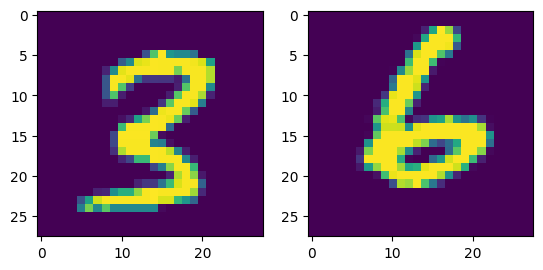

In [18]:
# for display and test digit :D
import random
import matplotlib.pyplot as plt

index = random.randint(0, 1000)
print(train_labels[index], test_labels[index])

train_image = np.asarray(get_image(train_images[index])).squeeze()
test_image = np.asarray(get_image(test_images[index])).squeeze()

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

Chuẩn bị dữ liệu huấn luyện

(785, 5000)
(10, 5000)


<Figure size 640x480 with 0 Axes>

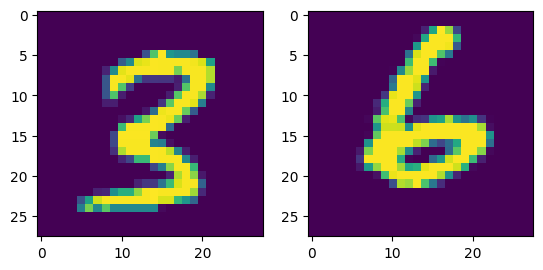

In [19]:
X_train = np.concatenate((np.ones((1, train_images.shape[0])), train_images.T), axis = 0)

Y_train = convert_labels(train_labels, 10)
print(X_train.shape)
print(Y_train.shape)

train_image = np.asarray(get_image(train_images[index])).squeeze()
test_image = np.asarray(get_image(test_images[index])).squeeze()

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

Chạy quá trình training và in ra loss function

In [20]:
theta = np.zeros((X_train.shape[0], 10))

opt_theta, losses = _softmax_regression(X_train, Y_train, theta)
print('training success: ', opt_theta.shape, len(losses))

epoch 0 - cost 0.7914065456952765
epoch 1 - cost 0.7863290063048243
epoch 2 - cost 0.7860076123030675
epoch 3 - cost 0.783068668808928
epoch 4 - cost 0.7791571896742794
epoch 5 - cost 0.7808549635558452
epoch 6 - cost 0.7808169303695108
epoch 7 - cost 0.776729134172506
epoch 8 - cost 0.7761642227900231
epoch 9 - cost 0.7787422800946957
epoch 10 - cost 0.7767928295136837
epoch 11 - cost 0.7759298782495202
epoch 12 - cost 0.7758705638140374
epoch 13 - cost 0.7755225629368764
epoch 14 - cost 0.7736944828152875
epoch 15 - cost 0.7772498916925955
epoch 16 - cost 0.7766065747471902
epoch 17 - cost 0.7759778400982216
epoch 18 - cost 0.7720789758609877
epoch 19 - cost 0.7737907130007566
training success:  (785, 10) 500


Tính các thông số về độ chính xác (gọi thư viện để chương trình không quá dài)

In [21]:
print('accuracy training data: ', accuracy_score(train_labels, pred(opt_theta, X_train)))

# test_images, test_labels = get_mnist_data(
# test_images_path, test_labels_path, 1000, _is=False, shuffle=False)
X_test = np.concatenate((np.ones((1, test_images.shape[0])), test_images.T), axis = 0)

print(X_test.shape)
print('accuracy testing data: ', accuracy_score(test_labels,

pred(opt_theta, X_test)))

accuracy training data:  0.944
(785, 10000)
accuracy testing data:  0.8642


### Bài tập thực hành

Sử dụng đoạn code chọn số chiều chính trong ví dụ 2, đưa tập dữ liệu đã đọc về còn 2 chiều, sau đó hiển thị lên màn hình để xem quan hệ giữa các lớp dữ liệu.

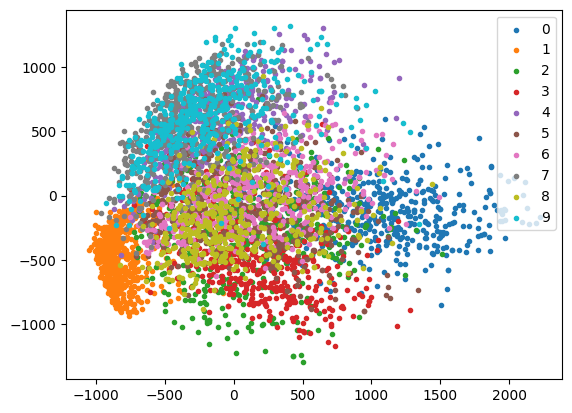

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transformed = pd.DataFrame(pca.fit_transform(train_images))

# Visualize
plt.scatter(transformed[train_labels == 0][0], transformed[train_labels == 0][1], s=9, label='0')
plt.scatter(transformed[train_labels == 1][0], transformed[train_labels == 1][1], s=9, label='1')
plt.scatter(transformed[train_labels == 2][0], transformed[train_labels == 2][1], s=9, label='2')
plt.scatter(transformed[train_labels == 3][0], transformed[train_labels == 3][1], s=9, label='3')
plt.scatter(transformed[train_labels == 4][0], transformed[train_labels == 4][1], s=9, label='4')
plt.scatter(transformed[train_labels == 5][0], transformed[train_labels == 5][1], s=9, label='5')
plt.scatter(transformed[train_labels == 6][0], transformed[train_labels == 6][1], s=9, label='6')
plt.scatter(transformed[train_labels == 7][0], transformed[train_labels == 7][1], s=9, label='7')
plt.scatter(transformed[train_labels == 8][0], transformed[train_labels == 8][1], s=9, label='8')
plt.scatter(transformed[train_labels == 9][0], transformed[train_labels == 9][1], s=9, label='9')
plt.legend()
plt.show()

Với đoạn chương trình đọc dữ liệu đã có, hãy chạy lại ví dụ này với các thư viện của gói linear_model, lớp LogisticRegression và so sánh kết quả.

In [ ]:
clf = LogisticRegression(multi_class='multinomial', solver='sag', random_state=2, max_iter=10000)
clf.fit(train_images, train_labels)

LogisticRegression(max_iter=10000, multi_class='multinomial', random_state=2,
                   solver='sag')

In [ ]:
train_pred = clf.predict(train_images)
print('Accuracy on training set:', accuracy_score(train_labels, train_pred))
print('Confusion matrix:\n', confusion_matrix(train_labels, train_pred))

test_pred = clf.predict(test_images)
print('Accuracy on test set:', accuracy_score(test_labels, test_pred))
print('Confusion matrix:\n', confusion_matrix(test_labels, test_pred))

Accuracy on training set: 1.0
Confusion matrix:
 [[498   0   0   0   0   0   0   0   0   0]
 [  0 597   0   0   0   0   0   0   0   0]
 [  0   0 525   0   0   0   0   0   0   0]
 [  0   0   0 513   0   0   0   0   0   0]
 [  0   0   0   0 475   0   0   0   0   0]
 [  0   0   0   0   0 438   0   0   0   0]
 [  0   0   0   0   0   0 453   0   0   0]
 [  0   0   0   0   0   0   0 517   0   0]
 [  0   0   0   0   0   0   0   0 487   0]
 [  0   0   0   0   0   0   0   0   0 497]]
Accuracy on test set: 0.8786
Confusion matrix:
 [[ 945    0   14    6    1   15   10    4    1    5]
 [   0 1126    4    9    0    4    8    0    6    0]
 [   4   16  885   27    5    8   16   14   44    8]
 [   3    2   24  863    2   68    4   20   28    6]
 [   5    0    8    3  913    0   14    8    5   59]
 [  10    6    7   58   12  697   17   10   55   13]
 [  17    4   20    2   20   19  909    8    3    6]
 [   1    9   29   18    3    5    1  897   11   42]
 [  13   13   23   33   10   63   16    4  706  